In [1]:
"""Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"""

"Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
from astropy.table import Table

In [4]:
import gfp_signal
from telegraph import exponential

In [5]:
import csv
import os

In [6]:
# helpful function for cutting the autocorrelation function into two parts (only want righthand side decay shape)
def findMiddleIndex(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return (int(middle))

In [7]:
""" create the array of MS2 loops, L, as a function of position, i
    ***NOTE*** in Desponds et al: "Li" ~should really be written L(i) 
    (adapted from Desponds et al Matlab code) """
import scipy.io as spio
def loopfn(despondsfile, tPol, k_elong, sizePol):
    # load in Desponds et al's loop function
    loopFn = spio.loadmat(despondsfile)
    
    ms = loopFn['ms']
    ms = ms[0]              # stupid matLab puts an array inside an array
    
    
    # make the L(i) function (array of values)
    Li_fn = []
    for i in range(len(ms)//sizePol):    
        Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
    if (i < len(ms) // sizePol):
        Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol
        
    return Li_fn

In [8]:
# define all needed parameters #
despondsfile = 'standalone/therightL.mat'
stepsize = 6            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

In [9]:
# Now let's simulate 100 traces to create a package of traces we'd expect to get from actual data.
# Parameters:
k_on = 0.0137
k_off = 0.0139
duration = 313   # seconds
stepsize = 6     # seconds / step

max_loops = 24   # max number of gfp loops that attach to each polII site


num = 200           # number of traces in our simulated dataset
auto_traces = []    # empty list of autocorrelation arrays
tracelist = []      # empty list of traces 
corrected_traces = []     # corrected traces
max_list = []

for i in range(num):
    tel = exponential(k_on, k_off, duration, stepsize)  # create a new signal every time      
    gfp = gfp_signal.gfp_signal(telegraph=tel.signal, k_elong=k_elong, max_loops=max_loops, tPol=tPol, stepsize=stepsize)
    
    trace = np.asarray(gfp.signal) 
    
    tracelist.append(trace)
    max_list.append(np.max(np.asarray(trace)))

In [10]:
# take in anterior cell cycle 13 data ... Pon should be about 0.45
table = Table.read('desponds_data/embryo1-anterior-nc13.csv')

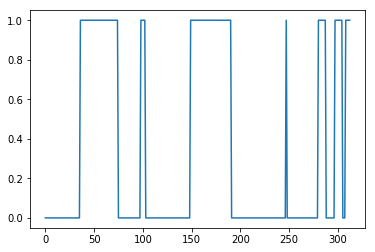

In [11]:
plt.plot(tel.signal)

In [12]:
tracelist = np.asarray(tracelist)

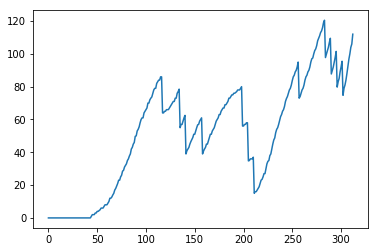

In [13]:
plt.plot(np.arange(len(tracelist[1])), tracelist[135])
plt.show()

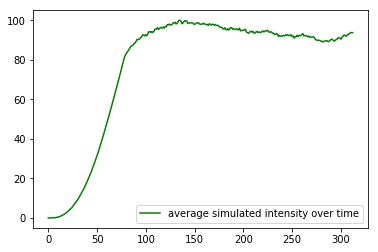

In [14]:
plt.plot(np.arange(len(tracelist[1])), np.mean(tracelist, axis=0), color='green', label='average simulated intensity over time')
plt.legend(loc='best')

plt.show()

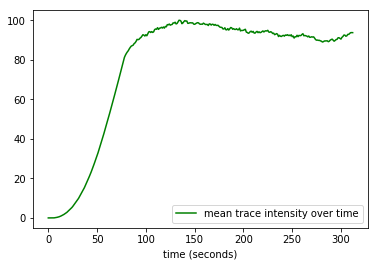

In [15]:
# plot mean intensity over time to define good steady-state window for embryo trace package
traces=[]
for name in table.colnames:
    trace = table[name]
    traces.append(trace)
    
seconds = np.arange(len(tracelist[0])) * stepsize

plt.plot(np.mean(tracelist, axis=0), color='green', label="mean trace intensity over time")
plt.xlabel('time (seconds)')
plt.legend()

In [16]:
# hard-code the autocorrelation of the signal from eq. (12) in Desponds et al
def autocorrelateSignal(trace):
    # over time-delay r
    auto_fn = []
    for r in range(len(trace)):
        sm1 = 0
        for i in range(len(trace)):
            for j in range(len(trace)):
                sm1 += trace[i]*trace[j]
        sm2 = 0.
        for k in range(len(trace)):
            #print(type(k))
            sm2 += (k^2)
        
        norm = ((len(trace)-float(r)) / len(trace)) * sm2
        auto_fn.append(sm1 / norm)
        return np.asarray(auto_fn)

In [17]:
start_index = 100
stop_index = -1

In [18]:
def tracePackageAutocorrelation(og_tracelist, start_index, stop_index):
    # compute autocorrelation with long time traces
    autolist = []
    tracelist = []
    tracelist_corr = []
    max_intens = []


    for j in og_tracelist:
    # calibrate fluorescence signal: F(t) = I(t) / Io, Io = <Imax> / sum(loop)
        max_intens.append(np.max(j[start_index:stop_index])) # get maximum fluorescence from each trace in given region

            # DO WE STILL COUNT ZERO SIGNAL CELLS????  --> yes, in fact, since they contribute to the average gene expression
            # for a given region.

    Imax = np.mean(np.asarray(max_intens))   # mean of the maxima of all traces in set
    
    I_o = Imax / np.sum(loopfn(despondsfile, tPol, k_elong, sizePol)) *150
    #print('Io = ', I_o)

    for trace in og_tracelist:
                
        # calibrate fluorescence signal: F(t) = I(t) / Io        
        calibrated_trace = trace / I_o   

        # subtract out mean signal of each trace to prevent nucleus-nucleus variability
        corrected_trace = calibrated_trace - np.nanmean(calibrated_trace)
        
        # check for weird zero traces and fill their autocorrelations with nans
        colsum = np.sum(trace)    

        if (colsum == 0):                                      # don't plot the zero signal traces
            auto_norm = np.ones(len(trace)) * np.nan         # set zero signal cells to nan to be ignored

        else: 
            auto = np.correlate(corrected_trace, corrected_trace, 'full')
            #auto = autocorrelateSignal(corrected_trace)
            auto = auto[np.argmax(auto):]     # take half of the autocorrelation function

            # finally, normalize        
            #auto_norm = auto / auto[0]
            for r in range(len(auto)):
                norm = []
                sm2 = 0.
                for k in range(1,len(corrected_trace)):
                    sm2 += (corrected_trace[k]**2)
                norm.append(((len(corrected_trace)-float(r)) / len(corrected_trace)) * sm2)

            auto_norm = auto / (np.asarray(norm))

        autolist.append(auto_norm) #/ auto_norm[1])   # normalize by second data point
        tracelist.append(calibrated_trace)
        tracelist_corr.append(corrected_trace)
        
    #plt.plot(tracelist[4])
    #print(np.mean(tracelist[3]))

    #plt.ylabel(r'$F(t) =$ $I(t)$ / $I_o$')
    #plt.show()
    
    autoav = np.nanmean(np.asarray(autolist), axis=0)
    autoav = autoav / autoav[1]
    autostd = np.nanstd(autoav, axis=0, ddof=np.arange(len(autoav)))
    
    return autoav[1:],tracelist_corr,autolist,tracelist,autostd[1:]

In [19]:
def traceTableAutocorrelation(table, start_index, stop_index):
    # compute autocorrelation with long time traces
    autolist = []
    tracelist = []
    tracelist_corr = []
    max_intens = []


    for j in table.colnames:
    # calibrate fluorescence signal: F(t) = I(t) / Io, Io = <Imax> / sum(loop)
        max_intens.append(np.max(table[j][start_index:stop_index])) # get maximum fluorescence from each trace in given region

            # DO WE STILL COUNT ZERO SIGNAL CELLS????  --> yes, in fact, since they contribute to the average gene expression
            # for a given region.

    Imax = np.mean(np.asarray(max_intens))   # mean of the maxima of all traces in set
    
    I_o = Imax / np.sum(loopfn(despondsfile, tPol, k_elong, sizePol)) *150
    #print('Io = ', I_o)

    for name in table.colnames:
        trace = table[name][start_index:stop_index]
        
        # calibrate fluorescence signal: F(t) = I(t) / Io        
        calibrated_trace = trace / I_o   

        # subtract out mean signal of each trace to prevent nucleus-nucleus variability
        corrected_trace = calibrated_trace - np.nanmean(calibrated_trace)
        
        # check for weird zero traces and fill their autocorrelations with nans
        colsum = np.sum(trace)    

        if (colsum == 0):                                      # don't plot the zero signal traces
            auto_norm = np.ones(len(trace)) * np.nan         # set zero signal cells to nan to be ignored

        else: 
            auto = np.correlate(corrected_trace, corrected_trace, 'same')
            #auto = autocorrelateSignal(corrected_trace)
            auto = auto[np.argmax(auto):]     # take half of the autocorrelation function

            # finally, normalize        
            #auto_norm = auto / auto[0]
            for r in range(len(auto)):
                norm = []
                sm2 = 0.
                for k in range(1,len(corrected_trace)):
                    sm2 += (corrected_trace[k]**2)
                norm.append(((len(corrected_trace)-float(r)) / len(corrected_trace)) * sm2)

            auto_norm = auto / (np.asarray(norm))

        autolist.append(auto_norm / auto_norm[1])   # normalize by second data point
        tracelist.append(calibrated_trace)
        tracelist_corr.append(corrected_trace)
        
    #plt.plot(tracelist[4])
    #print(np.mean(tracelist[3]))

    #plt.ylabel(r'$F(t) =$ $I(t)$ / $I_o$')
    #plt.show()
    
    autoav = np.nanmean(np.asarray(autolist), axis=0)
    autostd = np.nanstd(np.asarray(autolist), axis=0, ddof=np.arange(len(autoav)))
    
    return autoav[1:],tracelist_corr,autolist,tracelist,autostd[1:]

In [20]:
autoav,tracelist_corr,autolist,tracelist,autostd = tracePackageAutocorrelation(tracelist, start_index, stop_index)

In [21]:
t = np.arange(len(autoav))

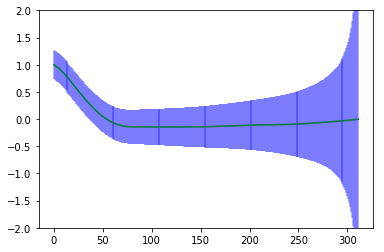

312


In [22]:
autoarr = np.asarray(autoav)

#for i in autolist:
    #plt.plot(t*stepsize,i[1:], alpha=0.3)

autocov = np.nanvar(autoarr, axis=0)
plt.plot(t, autoav, color = 'g', label = "average autocorrelation of trace data \n anterior cell cycle 13")
plt.errorbar(x=t, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.4, label = r'desponds data $\sigma$ standard error')  
#plt.legend(loc='best')
plt.ylim(-2,2)
plt.show()

print(len(autoav))

In [23]:
autostd;

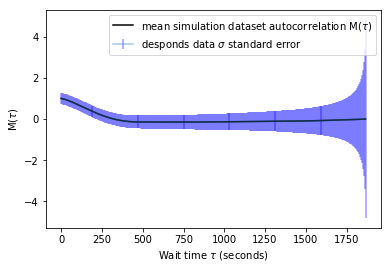

In [24]:
tau = np.arange(len(autoav))   # tau array to plot against

plt.errorbar(x=t*stepsize, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.4, label = r'desponds data $\sigma$ standard error')  

# show the mean of our original dataset in red
plt.plot(t*stepsize, autoav, color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$ (seconds)')
plt.ylabel(r'M($\tau$)')
plt.show()


In [25]:
# STEP TWO: Fit for value of Pon

In [26]:
# load in Desponds et al's loop function
import scipy.io as spio

loopFn = spio.loadmat('standalone/therightL.mat')

MS2 loop agglomeration rate =  0.019002375296912115 loops per basepair


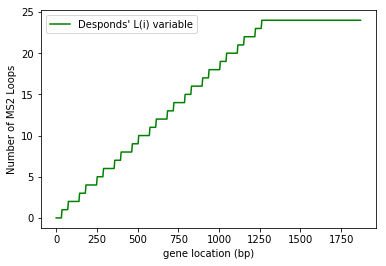

In [27]:
"""Parameters for Li model
ms: variable describing the number of binding sites on nascent mRNA
    ms[i] is the exact number of binding sites available when polII is 
    at the exact location i along the gene
Li: the number of binding sites on nascent mRNA given a BINNED position of polII i along gene"""
obs_time = 6  # seconds
tPol=6;       # RNAP loading time, corresponds to 1 polII every observation
k_elong=25;        # Elongation rate
sizePol = tPol * k_elong
variable = loopFn['ms']
ms = variable[0] 

plt.plot(np.arange(len(ms)), ms, color='green', label = 'Desponds\' L(i) variable')
plt.xlabel('gene location (bp)')
plt.ylabel('Number of MS2 Loops')
plt.legend(loc='best')
print('MS2 loop agglomeration rate = ', (24 / np.argmax(ms)), 'loops per basepair')

In [28]:
ms[1005]

18.25

In [29]:
"""Now, compute the binned loop Li function according to time spent on the gene"""
Li_fn_seconds = []
for i in range(len(ms)//sizePol):    
    Li_fn_seconds.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
#for i in range(len(loopfn)//sizePol):
if (i < len(ms) // sizePol):
    #print(i)
    Li_fn_seconds[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol

In [30]:
np.sum(Li_fn_seconds) / 150

1.1357777777777778

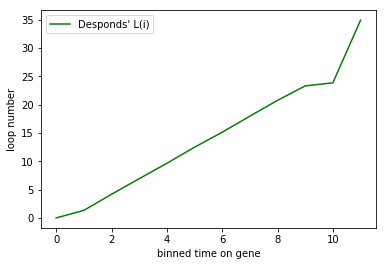

In [31]:
#plt.plot(np.asarray(Li_fn_seconds))
plt.plot(Li_fn_seconds, label = 'Desponds\' L(i)', color='g')
plt.xlabel('binned time on gene')
plt.ylabel('loop number')
plt.legend(loc='best')

In [32]:
""" create the array of MS2 loops, L, as a function of position, i
    ***NOTE*** in Desponds et al: "Li" ~should really be written L(i) 
    (adapted from Desponds et al Matlab code) """
import scipy.io as spio
def loopfn(despondsfile, tPol, k_elong, sizePol):
    # load in Desponds et al's loop function
    loopFn = spio.loadmat(despondsfile)
    
    ms = loopFn['ms']
    ms = ms[0]              # stupid matLab puts an array inside an array
    
    
    # make the L(i) function (array of values)
    Li_fn = []
    for i in range(len(ms)//sizePol):    
        Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
    #if (i < len(ms) // sizePol):
        #Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol
        
    return Li_fn

In [33]:
def getAverageFlors(tracelist):
    # compute average fluorescence for each raw simulated trace
    avg_flors = []
    for i in tracelist:
        avg_flors.append(np.mean(i))   # stack in an array
    return np.asarray(avg_flors)


In [34]:
avg_flors = getAverageFlors(tracelist)

(array([ 4., 10., 15., 27., 46., 41., 27., 21.,  5.,  4.]),
 array([0.22158503, 0.28256817, 0.3435513 , 0.40453444, 0.46551757,
        0.5265007 , 0.58748384, 0.64846697, 0.7094501 , 0.77043324,
        0.83141637]),
 <a list of 10 Patch objects>)

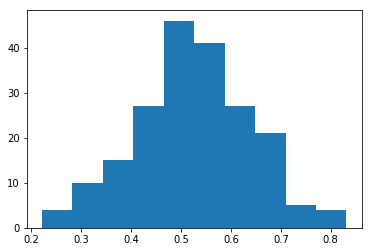

In [35]:
plt.hist(avg_flors)

In [36]:
# fit for pon in a SIMPLE way
def fitPon(tPol, k_elong, tracelist):
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # RNAP loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

    loops = loopfn(despondsfile, tPol, k_elong, sizePol)       # pull in loop function    
    avg_flors = getAverageFlors(tracelist)

    pon = np.mean(avg_flors) / np.sum(loops) * 150
    pon_var = np.std(avg_flors)**2

    return pon,pon_var

In [37]:
tPol=6;                      # RNAP loading time
k_elong=25;                  # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

p_on,pon_var = fitPon(tPol, k_elong, tracelist)
print('pon          = ', p_on, '\npon variance = ', pon_var)

pon          =  0.49401502479315035 
pon variance =  0.01353549145762921


In [38]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr_fn(average_fluorescence, p_on):
        
    # define parameters for Desponds Pon fitting
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # RNAP loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
        
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)       # pull in loop function    
    average_fluorescence = np.asarray(average_fluorescence)    # make into array
    
    # Divide by the FOOTPRINT in bp of one polII molecule.
    # This ensures that we are in units of number (loops/(polII bin)) * (1/150 (bp/(polII bin))                                                       # final units: loops / bp
    return p_on * np.sum(loops) / sizePol                    

In [39]:
# Calculate the mean v_avg, and variance v^2_avg of fluorescence signal for autocorrelation normalization factor
# v_avg is the average of the averages of each trace's intensity over the steady-state window. v_avg = mean(avg_fluorescence)
# v^2_avg is the average of the squares of the averages of each trace's intensity. v^2_avg = mean(avg_fluorescence^2)

def normFactor(average_fluorescence):
    avg_flors = np.asarray(average_fluorescence)

    v_avg = np.mean(avg_flors)        # calculate the mean of the flourescence
    
    f_sqs = np.zeros(len(avg_flors))
    for i in range(len(avg_flors)):   # calculate the squares of all of the trace averages
        f_sqs[i] = avg_flors[i]**2  

    v_sq_avg = np.mean(f_sqs)             # calculate the second moments
    
    return v_sq_avg - v_avg**2

In [40]:
normFactor(avg_flors)

0.013535491457629278

In [41]:
# now move on to fitting the autocorrelation function for the set of traces

In [42]:
""""
Autocorrelation function analysis for Two-State Model using Despond et al's (2016)
parameters:
    tPol: polII loading time
    k_elong:  MS2 GFP loop elongation rate along gene
    tPol:     polII loading time, assumed to load at every observation time
              ***NOTE: this is subject to change since there may exist a blocking time,
              or characteristic "traffic jam" time during polII loading ***
    sizePol:  "Footprint" or size of polII in basepairs, along gene
    
    k_gfp:    gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    
    FITTING FOR:
    ratesum: the inverse characteristic decay timescale for autocorrelation. Tells us how
              similar the signal is to itself and can reveal burst characteristics
              chartime = 1 / (k_on + k_off)
              
    Pon:      Probability that system is in "ON" state.
    k_on:     given as 1/mu for exponential distribution of ON wait times
    k_off:    1/mu for exponential distribution of OFF wait times

    ***NOTE: k_on and k_off decoupled by Pon = k_on / (k_on + k_off)
    """


def autocorr(t, chartime):  # take in parameters and t (signal data array index in seconds)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    stepsize = 6            # time between observations, seconds
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
    
    time = np.arange(len(t)) * stepsize
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)
    
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    #p_on = fitPon(tracelist)
    p_on = 0.49
    p_off = 1-p_on
    
    # compute normalization constant
    avg_flors = getAverageFlors(tracelist)
    normfactor = normFactor(avg_flors)

    
    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - chartime    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    
    c_arr = []
    
    for t in range(len(time)):
        sm0 = 0
        for i in range(len(loops)):
            for j in range(len(loops)):
                sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
     
        c_arr.append(sm0)
    #plt.plot(c_arr)
           
    connected_corr = np.asarray(c_arr)    # the two-state connected correlation function
    #return connected_corr / np.max(connected_corr)
   
    N = len(time)         # CONSTANT trace length
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    Co = connected_corr[0]    # initial condition of connected correlation function
        
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(1,N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(1,r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(1,N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
    
        # full correction
        corrected_full.append((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
        
    
    normed = (normfactor)*np.asarray(corrected_full)
    
    return (normed / normed[1])

In [43]:
# get our data's average autocorrelation function
dat = autoav   
t = np.arange(len(dat))

In [44]:
autoav_norm = autoav / np.max(autoav)
normlist = []
for i in autolist:
    normlist.append(i / np.max(i))

autostd_norm = np.nanstd(normlist, axis=0)[1:]


In [45]:
"""
When fitting the autocorrelation function within the standard deviation error range, we need to exclude the first point
since the standard error here is zero (all autocorr functions normalized there). Otherwise, we get a divide by zero and 
can't fit the fuction
"""
from scipy.optimize import curve_fit,least_squares
popt,pcov = curve_fit(autocorr, t[0:], autoav[0:], sigma=autostd[0:])

ratesum = popt[0]

kon_fit = ratesum*p_on
koff_fit = ratesum - kon_fit
chrtime = 1 / ratesum


C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


In [46]:
print("k_on + k_off              = ", ratesum, 's^-1')
print("k_on                      = ", kon_fit)
print("k_off                     = ", koff_fit)
print("t_polII_block             =  6 seconds")
print("characteristic timescale  = ", chrtime, 'time units')
print("covariance                = ", pcov[0][0])

k_on + k_off              =  0.03183287219524242 s^-1
k_on                      =  0.01572591714676987
k_off                     =  0.016106955048472548
t_polII_block             =  6 seconds
characteristic timescale  =  31.414067630047377 time units
covariance                =  8.167693559093495e-07


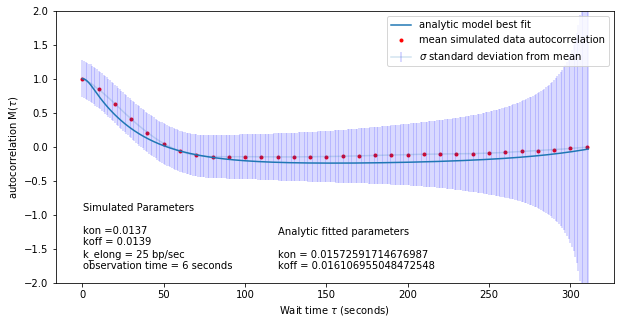

In [55]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, autocorr(t,chartime=popt[0]), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::10],autoav[::10], marker='.', color='r', label = 'mean simulated data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.2, label = r'$\sigma$ standard deviation from mean')  
plt.legend(loc="best")
ax.set_ylim(-2, 2)
ax.set_xlabel(r'Wait time $\tau$ (seconds)')
ax.set_ylabel(r'autocorrelation M($\tau$)')
plt.text(x=0.07, y=-1.8, 
             s='Simulated Parameters \n\nkon =' + str(k_on) +
                     '\nkoff = ' + str(k_off) +  '\nk_elong = '+ str(k_elong) 
                             + ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=120, y=-1.8, s='Analytic fitted parameters \n\nkon = ' + str(kon_fit) + '\nkoff = ' + str(koff_fit))
plt.show()

In [56]:
# Do a more packaged fitting with written functions. Bayesian fitting, assuming Gaussian error distributed 
# about each autocorrelated point, conservatively approximated by the standard error of autocorrelation

In [57]:
""""
Autocorrelation function analysis for Two-State Model using Despond et al's (2016)
parameters:
    tPol: polII loading time
    k_elong:  MS2 GFP loop elongation rate along gene
    tPol:     polII loading time, assumed to load at every observation time
              ***NOTE: this is subject to change since there may exist a blocking time,
              or characteristic "traffic jam" time during polII loading ***
    sizePol:  "Footprint" or size of polII in basepairs, along gene
    
    k_gfp:    gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    
    FITTING FOR:
    ratesum: the inverse characteristic decay timescale for autocorrelation. Tells us how
              similar the signal is to itself and can reveal burst characteristics
              chartime = 1 / (k_on + k_off)
              
    Pon:      Probability that system is in "ON" state.
    k_on:     given as 1/mu for exponential distribution of ON wait times
    k_off:    1/mu for exponential distribution of OFF wait times

    ***NOTE: k_on and k_off decoupled by Pon = k_on / (k_on + k_off)
    """


def autocorrModel(t, ratesum, p_on):  # take in parameters and t (signal data array index in seconds)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    stepsize = 6            # time between observations, seconds
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
    
    time = np.arange(len(t)) * stepsize
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)
    
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    #p_on = fitPon(tracelist)
    #p_on = 0.43
    p_off = 1-p_on
    
    # compute normalization constant
    avg_flors = getAverageFlors(tracelist)
    normfactor = normFactor(avg_flors)

    
    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - ratesum    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    
    c_arr = []
    
    for t in range(len(time)):
        sm0 = 0
        for i in range(len(loops)):
            for j in range(len(loops)):
                sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
     
        c_arr.append(sm0)
    #plt.plot(c_arr)
           
    connected_corr = np.asarray(c_arr)    # the two-state connected correlation function
    #return connected_corr / np.max(connected_corr)
   
    N = len(time)         # CONSTANT trace length
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    Co = connected_corr[0]    # initial condition of connected correlation function
        
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(1,N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(1,r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(1,N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
    
        # full correction
        corrected_full.append((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
        
    
    normed = (normfactor)*np.asarray(corrected_full)
    
    return (normed/ normed[1])

In [58]:
""" For this fit, we'll use the square of the standard error of the set of trace 
autocorrelations as our (conservative) inverse-variance. For this, we take the standard deviation
between each trace's data and the mean at each autocorrelated time point . """
y_err = autostd[1::10]   # our error (sigma) in y-data
y = autoav[1::10]        # our y-data that we wish to fit
t = t             # time delay x-axis of autocorrelation

tPol=6;                      # RNAP loading time
k_elong=25;                  # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

p_on,pon_var = fitPon(tPol, k_elong, tracelist)

print(p_on)

# pars = [chartime, p_on], where p_on is held fixed.

0.49401502479315035


In [50]:
class AutoCorrelationModel(object):

    def __init__(self, t, y, y_err, p_on):
        """
        What we're going to do is put all of the computation, from traces to 
        average autocorrelation, into one object for fitting
        """
        self.t = np.asarray(t)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)
        self.p_on = p_on
        
    def ln_likelihood(self, ratesum):
        N = len(self.y)     # number of data points
        dy = self.y - autocorrModel(self.t, ratesum, p_on) # difference in analytic model and data
        ivar = 1 / self.y_err**2                       # inverse-variance dependent on the sigmas of 
                                                       # trace autocorrelations
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))
        
        
    def ln_prior(self, ratesum):
        ratesum = ratesum    # might add more parameters later
        ln_prior_val = 0.      # to be added to 
        
        if ratesum < 0 or ratesum > 100.: 
            return -np.inf     # constrain chartime in sampling
        else:
            ln_prior_val += np.log(1E-2)  # normalization of log(1/100)
            
        return ln_prior_val
    
    def ln_posterior(self, ratesum):
        """
        log of posterior pdf is just the sum of ln(likelihood) + ln(prior)
        """
        lnp = self.ln_prior(ratesum)
        if np.isinf(lnp):  # stop if prior is infinite
            return lnp
        
        lnL = self.ln_likelihood(ratesum)
        lnprob = lnp + lnL
        
        if np.isnan(lnprob):
            return -np.inf
        
        return lnprob
    
    def __call__(self, ratesum):
        return self.ln_posterior(ratesum)
        

In [61]:
automodel = AutoCorrelationModel(t, y, y_err, p_on=p_on)

In [62]:
# Now implement Markov Chain Monte Carlo sampling
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def run_metropolis_hastings(p0, n_steps, model, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    model : StraightLineModel instance (or subclass)
        A callable object that takes a parameter vector and computes 
        the log of the posterior pdf.
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal 
        function. These are like STEP SIZES in each of the parameters.
    """
    
    p0 = np.array(p0)
    if len(proposal_sigmas) != len(p0):
        raise ValueError("Proposal distribution should have same shape as parameter vector.")

        
    # the objects we'll fill and return:
    chain = np.zeros((n_steps, len(p0))) # parameter values at each step
    ln_probs = np.zeros(n_steps) # log-probability values at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = model(p0)
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = model(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac
    

In [ ]:
p0 = [0.08]
chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=1000, model=automodel, 
                                           proposal_sigmas=[0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))

In [ ]:
fig,ax = plt.subplots(len(p0), 1, figsize=(10,5), sharex=True)

for i in range(len(p0)):
    ax.plot(chain[:,i], marker='', drawstyle='steps')

ax.legend(loc='best')
ax.set_ylabel('$kon+koff$')

fig.tight_layout()

In [ ]:
chain.shape

In [ ]:
good_samples = chain[20::8]
good_samples.shape

In [ ]:
from IPython import display
low,med,hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['kon + koff']):
    fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

In [ ]:
fig,ax = plt.subplots(len(p0), 1, figsize=(10,5), sharex=True)

ax.plot(t*6, autocorrModel(t,ratesum=med, p_on=p_on), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t*6,autoav_norm, marker='.', color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t*6, y=autoav_norm, yerr=(autostd, autostd), ecolor='b', alpha=0.2, label = r'desponds data $\sigma$ standard error')  
plt.legend()
ax.set_xlabel(r'Wait time $\tau$')
ax.set_ylabel(r'autocorrelation M($\tau$)')
plt.show()